# Projet SD701 -  Analyse des données

In [1]:
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import cluster, linear_model
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as axis
import seaborn as sns

from xml.dom import minidom
from lxml import etree
from bs4 import BeautifulSoup
import io
from os import listdir
import random
import json

import datetime
import time
from meteostat import Point, Daily, Hourly
from operator import itemgetter

# Ouverture des df

## df_dep

In [2]:
# fonction pour mettre tous les codes départements en str
def chang_str(x):
    try:
        return str(int(x))
    except:
        return str(x)

In [3]:
# import des départements
with open('depreg.geojson') as fic_depreg:
    depreg = json.load(fic_depreg)
df_dep = pd.DataFrame({'num':[i['properties']['code']for i in depreg['features']],
                      'poly_dep': [i['geometry']['coordinates'] for i in depreg['features']]})
df_dep['num'] = df_dep['num'].apply(chang_str)
df_dep.head()

,num,poly_dep
0,2,"[[[3.172704445659, 50.011996744997], [3.182197..."
1,10,"[[[3.4147888224632, 48.390268550005], [3.42207..."
2,14,"[[[-1.1196198636379, 49.355568981262], [-1.115..."
3,15,"[[[2.5084125130653, 45.478501516921], [2.52443..."
4,28,"[[[0.8148247207739, 48.670163564137], [0.82767..."


In [4]:
# récupération des polygones
def ret_lis(l, w):
    if type(l[0][0]) != float:
        for i in l:
            ret_lis(i, w)
    else:
            w.append(l)
    return w

# fonction permettant d'afficher sur carte les départements
def dep(lis_dep):
    compteur = 0
    for i in df_dep.loc[df_dep['num'].isin(lis_dep), 'poly_dep']:
        w=[]
        polys = ret_lis(i, w)
        #pt_moy = [0,0]
        for poly in polys:
            x, y = [j[0] for j in poly], [j[1] for j in poly]
            plt.plot(x, y, c='k', alpha = 0.3)
            #pt_moy[0] = pt_moy[0] + sum(x)/len(x)/len(polys)
            #pt_moy[1] = pt_moy[1] + sum(y)/len(y)/len(polys)
        #plt.text(pt_moy[0], pt_moy[1], df_dep['num'][compteur], size = 6)
        compteur +=1

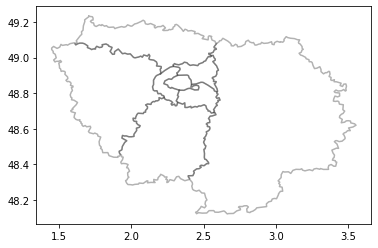

In [5]:
IDF = ['75','91','92', '93', '94', '95', '78', '77']
dep(IDF)

## df_sites

In [21]:
# df_sites
fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1]=='sites'], 
                                    key=itemgetter(2,3))[-1])
print('ouverture de %s\n' % fic )
df_sites = pd.read_csv(fic, index_col = None, low_memory=False)
df_sites.head()

ouverture de dataset/df_sites_20211125_091353.csv



,code site,nom site,lat,long,alt,Altitude Moyenne,Code INSEE,Code Postal,Commune,Département,...,Statut,Superficie,Population,geo_shape,poly_dep,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,FR01001,Longlaville-Ecole,49.535004,5.804447,265.0,294.0,54321,54810,LONGLAVILLE,MEURTHE-ET-MOSELLE,...,Commune simple,313.0,2.5,"{""type"": ""Polygon"", ""coordinates"": [[[5.804438...","[[[[5.4555586843759, 49.480931549678], [5.4495...",321,30,1,54,41
1,FR01004,Distroff,49.332497,6.271664,223.0,204.0,57179,57925,DISTROFF,MOSELLE,...,Commune simple,798.0,1.6,"{""type"": ""Polygon"", ""coordinates"": [[[6.250460...","[[[7.6352815933424, 49.054164206261], [7.63470...",179,21,7,57,41
2,FR01005,Hayange,49.324722,6.076108,187.0,253.0,57306,57700,HAYANGE,MOSELLE,...,Chef-lieu canton,1223.0,15.5,"{""type"": ""Polygon"", ""coordinates"": [[[6.094813...","[[[7.6352815933424, 49.054164206261], [7.63470...",306,15,8,57,41
3,FR01006,Florange,49.320830,6.140000,158.0,177.0,57221,57190,FLORANGE,MOSELLE,...,Chef-lieu canton,1318.0,11.2,"{""type"": ""Polygon"", ""coordinates"": [[[6.132507...","[[[7.6352815933424, 49.054164206261], [7.63470...",221,39,8,57,41
4,FR01009,Gandrange,49.271393,6.132500,180.0,180.0,57242,57175,GANDRANGE,MOSELLE,...,Commune simple,411.0,2.9,"{""type"": ""Polygon"", ""coordinates"": [[[6.153646...","[[[7.6352815933424, 49.054164206261], [7.63470...",242,22,8,57,41


## df_tot

In [7]:
# ouverture du dernier df_tot

fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1]=='tot'], 
                                    key=itemgetter(2,3))[-1])
print('ouverture de %s\n' % fic )
df_tot = pd.read_csv(fic)
df_tot.drop(df_tot.columns[0], axis = 1, inplace = True)
df_tot['GDH'] = pd.to_datetime(df_tot['GDH'])
df_tot['Code Département'] = df_tot['Code Département'].apply(chang_str)
df_tot.drop(df_tot.loc[df_tot['tavg'].isnull()].index, axis = 0, inplace = True)
df_tot.drop(['snow', 'wdir','wspd','wpgt', 'tsun'], axis = 1, inplace = True)
df_tot.head()

ouverture de dataset/df_tot_20211129_201207.csv



,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,alt,Population,Code Département,tavg,tmin,tmax,prcp,pres,Jx,Jy
0,2019-10-06,FR04055,48027.0,6001,2,1,10.222727,29.0,0.2,48.86212,...,35.0,17.6,75,15.2,13.5,18.6,4.3,1013.9,0.623490,-0.781831
1,2019-10-08,FR04055,56028.0,6001,2,1,16.279167,25.7,8.0,48.86212,...,35.0,17.6,75,14.1,13.1,15.8,4.3,1012.5,0.623490,0.781831
2,2019-10-09,FR04055,56852.0,6001,2,1,6.436047,14.5,2.0,48.86212,...,35.0,17.6,75,13.0,11.0,17.1,5.6,1012.2,-0.222521,0.974928
3,2019-10-17,FR04055,56673.0,6001,2,1,4.466343,9.1,0.6,48.86212,...,35.0,17.6,75,14.5,12.2,16.9,4.1,1010.4,-0.900969,0.433884
4,2019-10-26,FR04055,50811.0,6001,2,1,9.634783,16.3,6.3,48.86212,...,35.0,17.6,75,15.0,11.0,20.4,0.3,1017.2,-0.222521,-0.974928


In [8]:
# on prend le parti de supprimer toute ligne possédant un NaN
df_tot.drop(df_tot[df_tot.isna().any(axis = 1)].index, axis = 0, inplace = True)

In [9]:
df_tot

,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,alt,Population,Code Département,tavg,tmin,tmax,prcp,pres,Jx,Jy
0,2019-10-06,FR04055,48027.0,6001,2,1,10.222727,29.00,0.200000,48.862120,...,35.0,17.6,75,15.2,13.5,18.6,4.3,1013.9,0.623490,-0.781831
1,2019-10-08,FR04055,56028.0,6001,2,1,16.279167,25.70,8.000000,48.862120,...,35.0,17.6,75,14.1,13.1,15.8,4.3,1012.5,0.623490,0.781831
2,2019-10-09,FR04055,56852.0,6001,2,1,6.436047,14.50,2.000000,48.862120,...,35.0,17.6,75,13.0,11.0,17.1,5.6,1012.2,-0.222521,0.974928
3,2019-10-17,FR04055,56673.0,6001,2,1,4.466343,9.10,0.600000,48.862120,...,35.0,17.6,75,14.5,12.2,16.9,4.1,1010.4,-0.900969,0.433884
4,2019-10-26,FR04055,50811.0,6001,2,1,9.634783,16.30,6.300000,48.862120,...,35.0,17.6,75,15.0,11.0,20.4,0.3,1017.2,-0.222521,-0.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222651,2021-03-01,FR24007,68219.0,8,2,1,21.562025,83.70,3.700000,43.598804,...,81.0,75.6,6,11.6,8.4,13.2,0.0,1029.4,1.000000,0.000000
2222652,2021-03-01,FR24007,68219.0,8,3,1,29.463993,67.50,9.608333,43.598804,...,81.0,75.6,6,11.6,8.4,13.2,0.0,1029.4,1.000000,0.000000
2222653,2021-03-04,FR24007,65598.0,8,3,1,31.959618,59.25,18.380000,43.598804,...,81.0,75.6,6,11.1,9.0,12.9,0.0,1023.2,-0.900969,0.433884
2222654,2021-03-05,FR24007,68054.0,8,3,1,30.971196,54.67,16.960000,43.598804,...,81.0,75.6,6,10.9,8.2,12.9,0.0,1016.7,-0.900969,-0.433884


In [10]:
# standardisation des métriques utilisées, on groupe par type de polluant

poll = set(df_tot['type_poll'])
dataset=[]
for i in poll:
    part = df_tot.groupby('type_poll').get_group(i)
    for j in ['mesure', 'mesure_max', 'mesure_min']:
        a = (part[j] - part[j].mean())/part[j].std()
        part[j] = a
    dataset.append(part)
df_tot = pd.concat(dataset)
df_tot.reset_index(inplace = True)
df_tot.drop(df_tot.columns[0], axis = 1, inplace = True)
df_tot.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,alt,Population,Code Département,tavg,tmin,tmax,prcp,pres,Jx,Jy
0,2018-09-23,FR02033,45812.0,1,3,1,8.821784,3.004582,7.766722,43.339893,...,47.0,46.6,13,25.0,19.5,31.8,0.0,1018.0,0.623490,-0.781831
1,2018-09-25,FR02033,54301.0,1,3,1,-0.215870,-0.048974,-0.159241,43.339893,...,47.0,46.6,13,19.3,13.5,25.6,0.0,1025.7,0.623490,0.781831
2,2018-10-02,FR02033,57235.0,1,2,1,0.633905,0.917720,-0.159241,43.339893,...,47.0,46.6,13,15.8,12.2,21.0,0.0,1017.0,0.623490,0.781831
3,2018-10-03,FR02033,56676.0,1,2,1,-0.426313,-0.345627,-0.159241,43.339893,...,47.0,46.6,13,16.6,8.4,24.9,0.0,1020.0,-0.222521,0.974928
4,2018-10-04,FR02033,55391.0,1,3,1,-0.321853,-0.212013,-0.159241,43.339893,...,47.0,46.6,13,18.4,10.6,26.5,0.0,1020.7,-0.900969,0.433884


In [11]:
df_tot.columns

Index(['GDH', 'code site', 'PicJourConsoNat', 'type_poll', 'verif', 'valid',
       'mesure', 'mesure_max', 'mesure_min', 'lat', 'long', 'alt',
       'Population', 'Code Département', 'tavg', 'tmin', 'tmax', 'prcp',
       'pres', 'Jx', 'Jy'],
      dtype='object')

# Visualisation

In [12]:
# fonction d'affichage des moyennes des mesures sur une période donnée et dans des départements donnés
def graph_poll(date_start, date_end, lis_dep, lab = False, graph = False):
    a = df_tot.loc[df_tot['Code Département'].isin(lis_dep)]
    a = a.set_index('GDH').loc[date_start:date_end].groupby(['code site']).agg({'mesure':'mean', 
                                                           'Code Département': 'first',
                                                           'lat':'first',
                                                           'long': 'first'})
    if graph == True:
        plt.figure(figsize=(15,10))
    dep(lis_dep)
    var = plt.scatter(a['long'], a['lat'], c = a['mesure']*10, cmap=plt.cm.Spectral_r,
                      edgecolors='none', s=200, alpha = 0.7)
    plt.xlabel('longitude', size = 15)
    plt.ylabel('lattitude', size = 15)
    plt.colorbar(var, label='pollution')
    if date_start == date_end:
        plt.title(f'Pollution en {date_end}', size = 20)
    else:
        plt.title(f'Pollution du {date_start} au {date_end}', size = 20)
    if lab == True:
        a = pd.merge(a, df_sites[['code site','Commune']], left_on = 'code site', right_on = 'code site', how = 'left')
        for x, y, text in zip(a['long'], a['lat'], a['Commune']):
            plt.annotate(text, (x,y))
    if graph == True:
        plt.show()

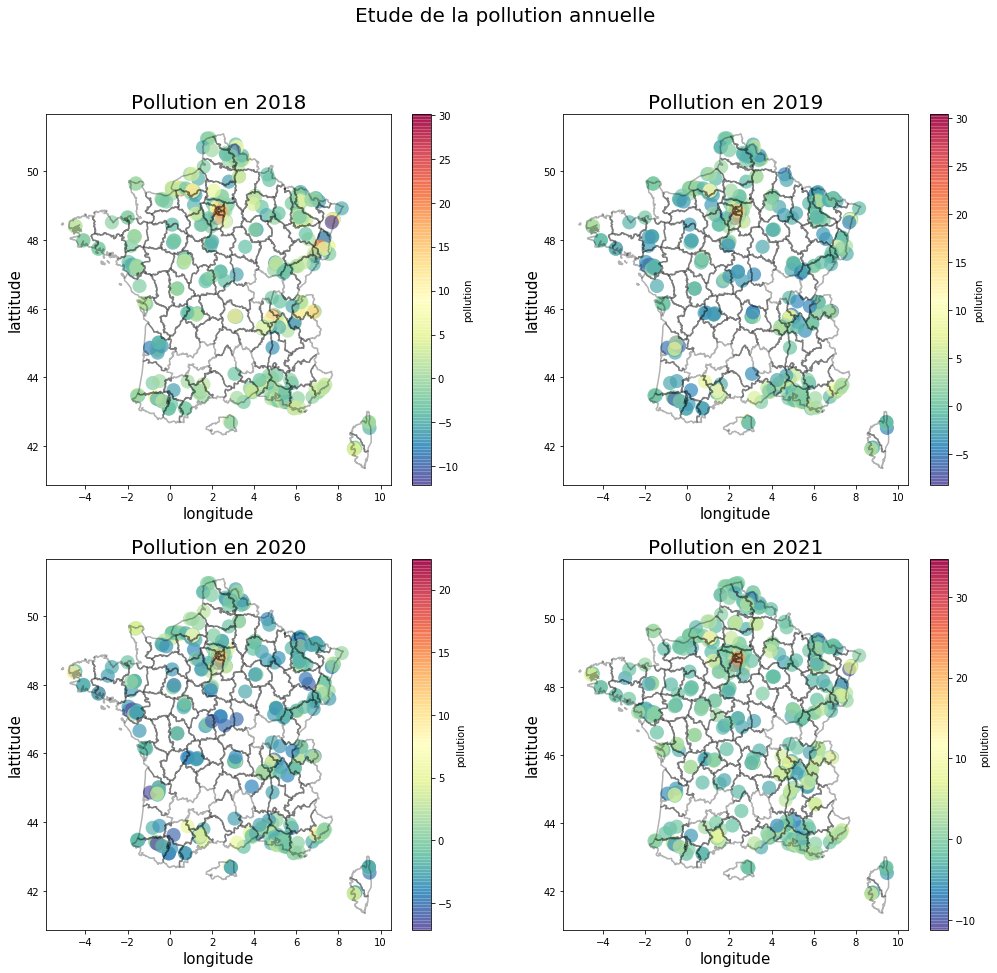

In [13]:
plt.figure(figsize=(17,15))
plt.suptitle('Etude de la pollution annuelle', size = 20)
for i in range(4):
    plt.subplot(2, 2, i+1)
    graph_poll(str(2018+i), str(2018+i), set(df_tot['Code Département']))
plt.show()

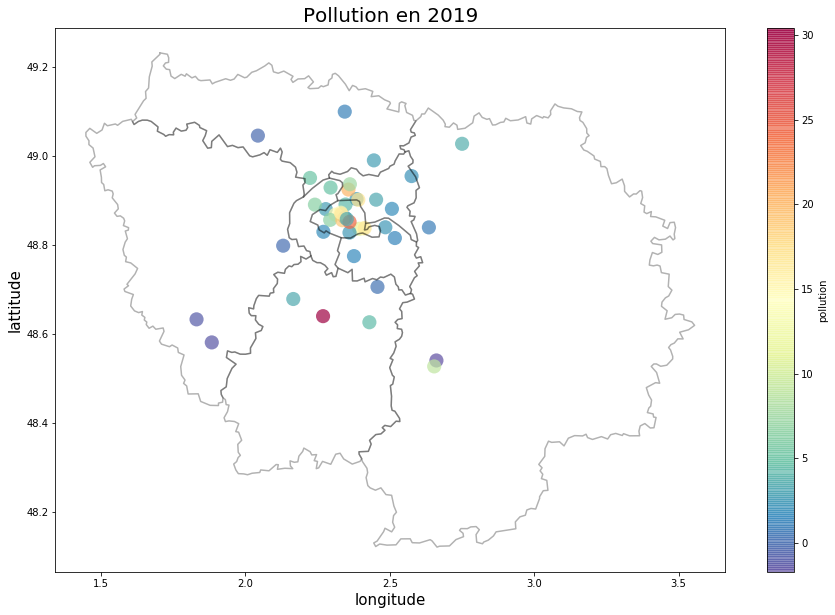

In [17]:
graph_poll('2019', '2019', IDF, lab=False, graph=True)

In [19]:
df_sites

,code site,nom site,lat,long,alt
0,FR01001,Longlaville-Ecole,49.535004,5.804447,265.0
1,FR01004,Distroff,49.332497,6.271664,223.0
2,FR01005,Hayange,49.324722,6.076108,187.0
3,FR01006,Florange,49.320830,6.140000,158.0
4,FR01009,Gandrange,49.271393,6.132500,180.0
...,...,...,...,...,...
828,FR82200,Besancon pl Leclerc,47.242500,6.015200,281.0
829,FR82210,Bouclans (Nancray),47.245800,6.183600,335.0
830,FR82220,Sochaux Mairie,47.513100,6.831800,321.0
831,FR82512,Besancon rue Vesoul,47.253292,6.016094,309.0


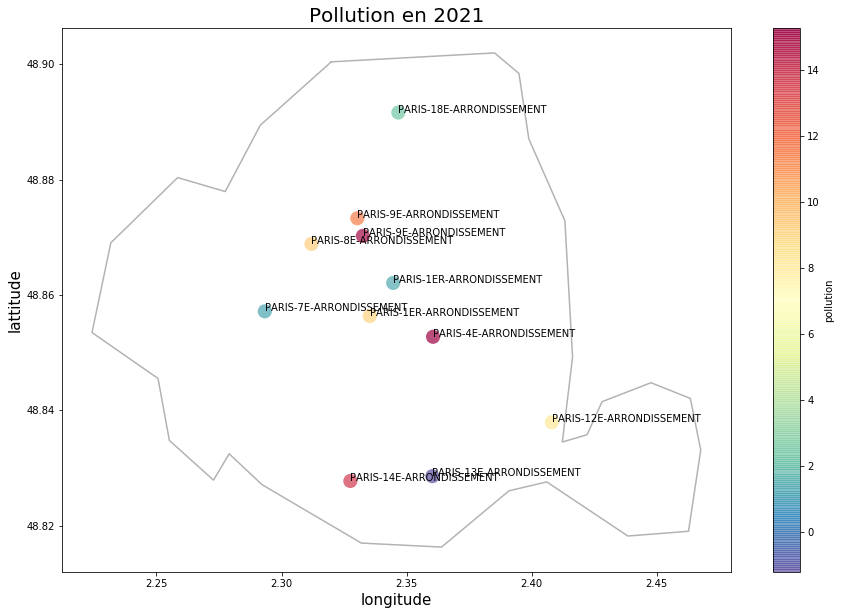

In [22]:
graph_poll('2021', '2021', ['75'], lab=True, graph = True)

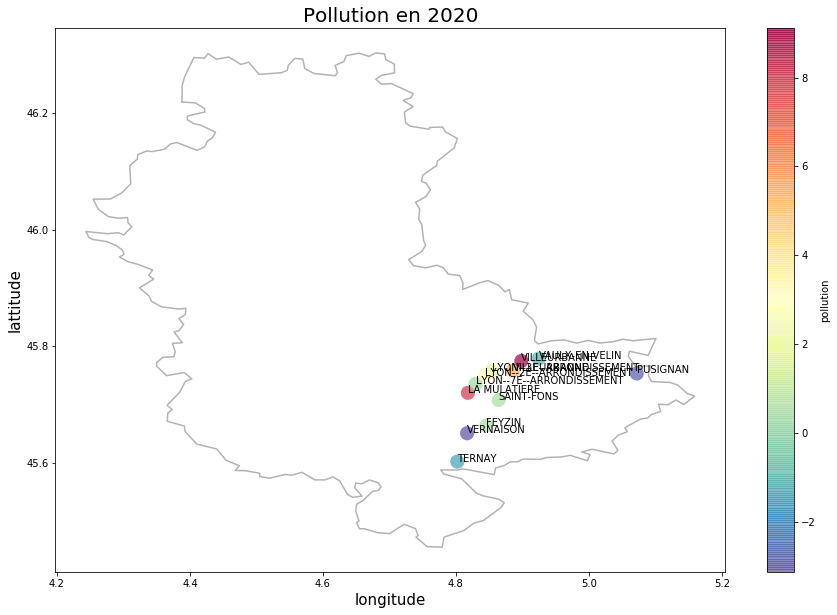

In [23]:
graph_poll('2020', '2020', ['69'], lab=True, graph = True)

# KMeans

In [24]:
df_tot.columns

Index(['GDH', 'code site', 'PicJourConsoNat', 'type_poll', 'verif', 'valid',
       'mesure', 'mesure_max', 'mesure_min', 'lat', 'long', 'alt',
       'Population', 'Code Département', 'tavg', 'tmin', 'tmax', 'prcp',
       'pres', 'Jx', 'Jy'],
      dtype='object')

In [25]:
# standardisation des métriques utilisées, on groupe par type de polluant
df_tot_std = df_tot.copy()
for i in ['mesure','mesure_max','mesure_min', 'alt', 'tavg', 'tmin', 'tmax',
          'prcp','prcp','pres', 'PicJourConsoNat', 'Population',
         'Jx', 'Jy']:
    a = StandardScaler().fit_transform(np.array(df_tot_std[i]).reshape(-1,1))
    df_tot_std[i] = a

# standardisation des coordonnées: on garde aussi les vraies coordonnées pour les mapper
df_tot_std['lat_cr'] = StandardScaler().fit_transform(np.array(df_tot['lat']).reshape(-1,1))
df_tot_std['long_cr'] = StandardScaler().fit_transform(np.array(df_tot['lat']).reshape(-1,1))

# nettoyage des données:
#df_tot = df_tot#.fillna(method='bfill')
#df_tot = df_tot.loc[df_tot['mean']<10]
    
df_tot_std.head()

,GDH,code site,PicJourConsoNat,type_poll,verif,valid,mesure,mesure_max,mesure_min,lat,...,Code Département,tavg,tmin,tmax,prcp,pres,Jx,Jy,lat_cr,long_cr
0,2018-09-23,FR02033,-1.355028,1,3,1,8.821807,3.004590,7.766743,43.339893,...,13,1.890986,1.876290,1.870339,-0.407749,0.135226,0.913773,-1.184771,-1.47736,-1.47736
1,2018-09-25,FR02033,-0.590960,1,3,1,-0.215870,-0.048974,-0.159242,43.339893,...,13,1.026681,0.877713,1.076525,-0.407749,0.984498,0.913773,1.047821,-1.47736,-1.47736
2,2018-10-02,FR02033,-0.326880,1,2,1,0.633907,0.917723,-0.159242,43.339893,...,13,0.495967,0.661355,0.487567,-0.407749,0.024931,0.913773,1.047821,-1.47736,-1.47736
3,2018-10-03,FR02033,-0.377194,1,2,1,-0.426315,-0.345628,-0.159242,43.339893,...,13,0.617273,0.028923,0.986901,-0.407749,0.355816,-0.275024,1.323523,-1.47736,-1.47736
4,2018-10-04,FR02033,-0.492852,1,3,1,-0.321854,-0.212014,-0.159242,43.339893,...,13,0.890211,0.395068,1.191756,-0.407749,0.433023,-1.228366,0.551022,-1.47736,-1.47736


On regroupe les polluants en prenant la moyenne de pollution par jour et par site 

In [26]:
# df_mean: df de moyenne de la pollution sur les trois ans par site
df_mean = df_tot_std.groupby(['code site', 'Code Département']).agg({
                                         'PicJourConsoNat':'mean',
                                        'Population':'mean',
                                         'alt':'mean',
                                         'lat':'first',
                                         'lat_cr':'first',
                                         'long':'first',
                                         'long_cr':'first',
                                         'prcp':'mean',
                                         'pres':'mean',
                                         #'snow':'mean',
                                         'tavg':'mean',
                                         'tmax':'mean',
                                         'tmin':'mean',
                                         #'tsun':'mean',
                                         #'wdir':'mean',
                                         #'wpgt':'mean',
                                         #'wspd':'mean',
                                        'mesure':'mean'}).reset_index().fillna(method='bfill')

On teste tout d'abord le KMeans sur toutes les métriques numériques


In [27]:
# clustering par k-means:
def km(df, nb_clust, graph=True):
    dfk = df.fillna(0)
    #.loc[df_mean['GDH'].dt.]
    #dfk = dfk.loc[dfk['mean']<10]

    kmeans_algo = cluster.KMeans(n_clusters=nb_clust)
    kmeans_results = kmeans_algo.fit_transform(dfk[['mesure', 'Population',
                                                    'alt', 
                                                    'lat_cr', 'long_cr',
                                                    #'PicJourConsoNat',
                                                    #'lat', 'long',
                                                    'tavg',  'pres', 'prcp', 
                                                    ]])

    dfk['classification'] = kmeans_algo.labels_
    colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(nb_clust)])
    #création d'une liste comportant tous les binômes de paramètres étudiés
    L = ['alt',  'tavg','pres', 'prcp', 'lat', 'Population']

    #représentation des six nuages de points pour identifier visuellement le(s) binôme(s) le(s) plus pertinent:
    if graph == True:
        plt.figure(figsize=(15,10))
        for i in range(len(L)):
            plt.subplot(2,3,i+1)
            plt.scatter(dfk[L[i]],dfk['mesure'], c=colormap[kmeans_algo.labels_], alpha = 0.5, s=10)
            plt.title('Pollution'+' / '+dfk[L[i]].name)
        plt.subplot(2,3,6)
        #plt.scatter(dfk['Jx'],dfk['Jy'], c=colormap[classification], alpha = 0.5, s=10)
        #plt.title('Jy/Jx')
        plt.show()
    
        # Affichage sur la carte
        plt.figure(figsize=(12,12))
    
    # on rajoute le dept 11 qui n'a pas de station de mesure si le Df prend en compte toute la France
    if set(dfk['Code Département']) == set(df_tot['Code Département']):
        dep(list(set(dfk['Code Département']))+['11'])
    else:
        dep(set(dfk['Code Département']))
    
    for i in set(kmeans_algo.labels_):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'], 
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha = 0.5,
                    c=colormap[i],
                    label = f'clust {str(i+1)}')
    plt.title(f'K-means à {nb_clust} clusters', size = 20)
    plt.xlabel('longitude')
    plt.ylabel('lattitude') 
    if graph == True:      
        plt.legend()
        plt.show()

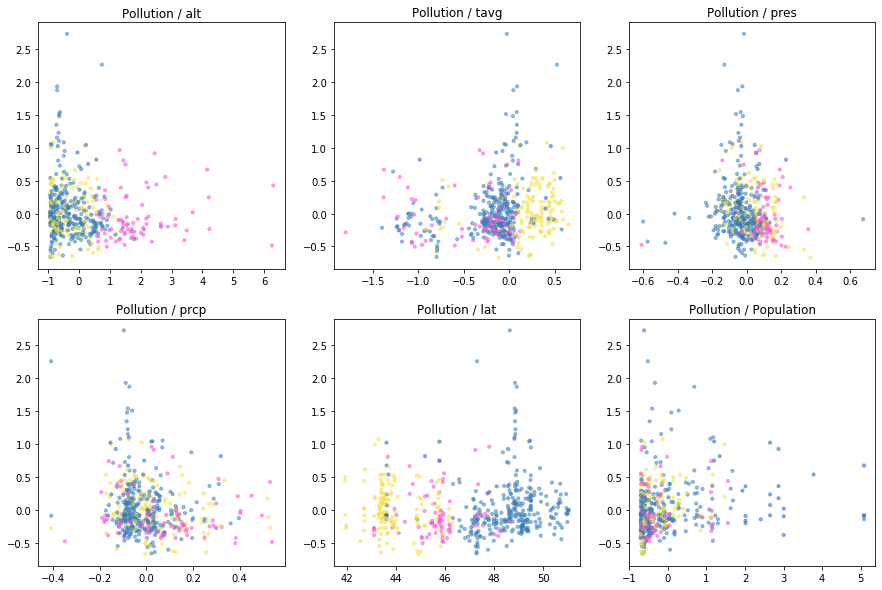

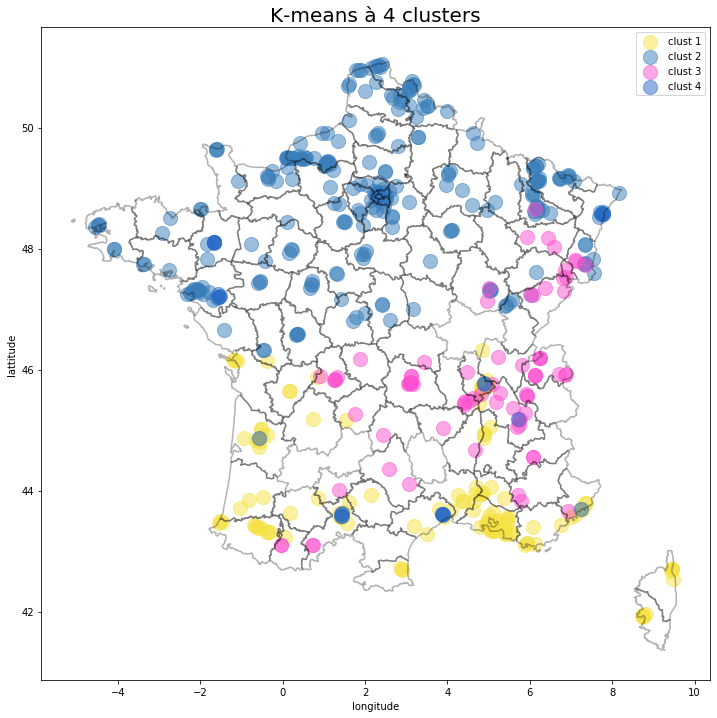

In [28]:
km(df_mean, 4)

On remarque que le Kmeans effectué ci-dessus n'est pas adapté car la distance sur les métriques de coordonnées prend le pas sur les autres métriques. il faut alors augmenter la valeur de pollution

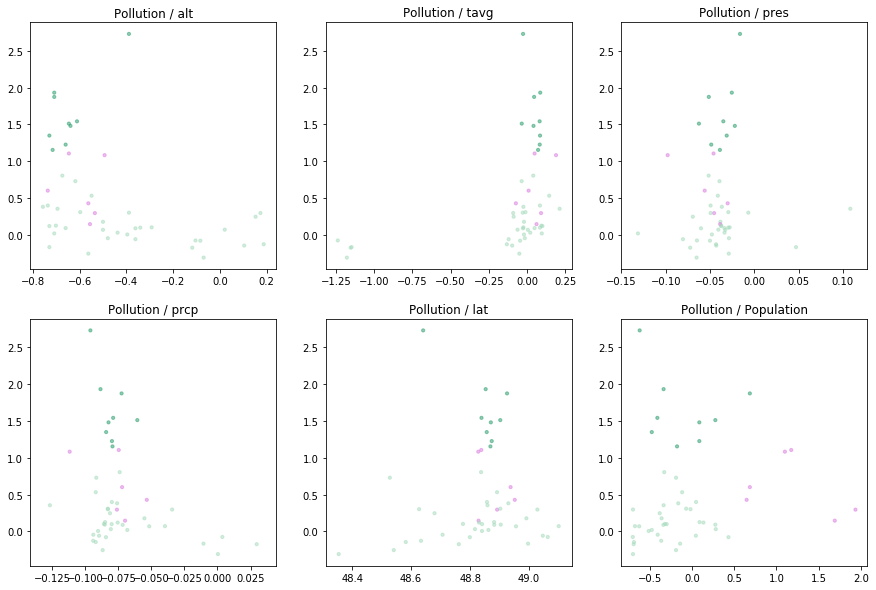

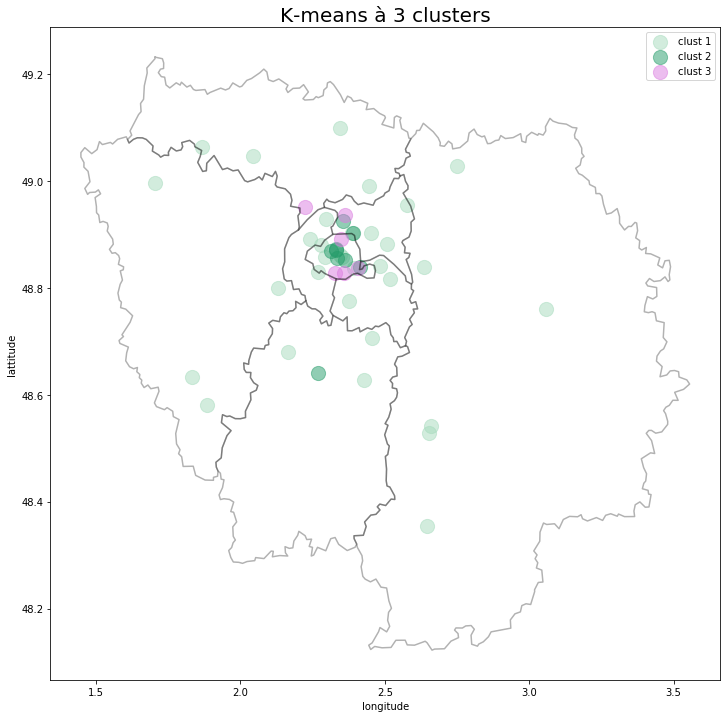

In [29]:
df_idf = df_mean.loc[df_mean['Code Département'].isin(IDF)]
km(df_idf, 3)

## Calcul de la distortion

In [30]:
def elb(kmin, kmax):
    
    elbow_score = []
    for k in range(kmin, kmax+1):
        dfk = df_mean.fillna(0)[['mesure', 'Population',
                                                'alt', 
                                                'lat_cr', 'long_cr',
                                                #'PicJourConsoNat',
                                                #'lat', 'long',
                                                'tavg',  'pres', 'prcp', 
                                                ]]
        kmeans_algo = cluster.KMeans(n_clusters=k)
        kmeans_results = kmeans_algo.fit_transform(dfk)
        dfk['label'] = kmeans_algo.labels_
        dist = []
        for i in range(k):
            dist.append(((dfk.groupby('label').get_group(i).drop('label', axis=1)-kmeans_algo.cluster_centers_[i]).apply(abs)**2).sum().sum())

        elbow_score.append(sum(dist))
    
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(kmin,kmax+1,1),  elbow_score)
    plt.title(f'Elbow_score pour k de {kmin} à {kmax}', size = 20)
    plt.xlabel('nombre de clusters')
    plt.ylabel('elbow_score')
    plt.grid()
    plt.show()

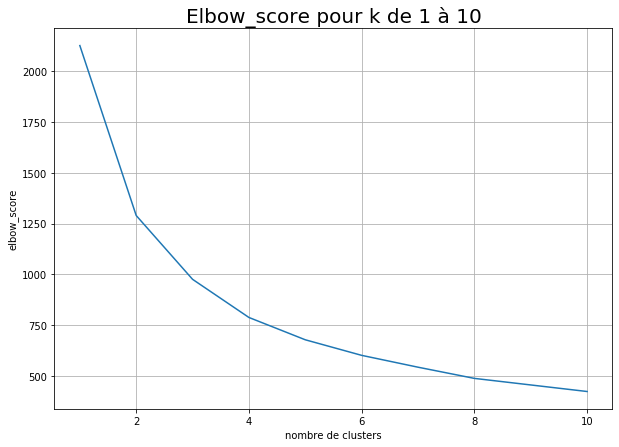

In [31]:
elb(1,10)

# Classification par arbre avec PCA

In [32]:
# Birch avce PCA

def BC(df, nb_clust=None, nb_comp_pca = 3, graph = True):
    dfk = df.fillna(0)
    brc = cluster.Birch(n_clusters=nb_clust)
    dfk_test = dfk[['mesure', 'Population',
                                                'alt', 
                                                'lat_cr', 'long_cr',
                                                #'PicJourConsoNat',
                                                #'lat', 'long',
                                                'tavg', 'prcp',  'pres' 
                                                ]]
    pca = PCA(n_components=nb_comp_pca)
    pca.fit(dfk_test)
    df_pca = pca.fit_transform(dfk_test)
    brc.fit(df_pca)
    classification =  brc.predict(df_pca)
    dfk['classification'] = pd.DataFrame(classification)
    #if nb_clust == None:
        #colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(len(set(classification)))])
    #else:
                #colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(nb_clust)])
    
    colormap = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
    #création d'une liste comportant tous les binômes de paramètres étudiés
    L = ['alt',  'tavg','pres', 'prcp', 'lat_cr', 'Population']

    #représentation des six nuages de points pour identifier visuellement le(s) binôme(s) le(s) plus pertinent:
    if graph == True:
        plt.figure(figsize=(15,10))
        for i in range(len(L)):
            plt.subplot(2,3,i+1)
            plt.scatter(dfk[L[i]],dfk['mesure'], c=[colormap[j] for j in classification], alpha = 0.5, s=10)
            plt.title('Pollution'+' / '+dfk[L[i]].name)
        plt.subplot(2,3,6)
        #plt.scatter(dfk['Jx'],dfk['Jy'], c=colormap[classification], alpha = 0.5, s=10)
        #plt.title('Jy/Jx')
        plt.show()
    
        # Affichage sur la carte
        plt.figure(figsize=(12,12))

    dep(set(dfk['Code Département']))
            
    for i in set(classification):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'], 
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha = 0.5,
                    c=colormap[i],
                    label = f'clust {str(i+1)}')
    plt.title(f'Birch à {nb_clust} clusters avec PCA', size = 20)
    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    if graph == True:
        plt.legend()
        plt.show()

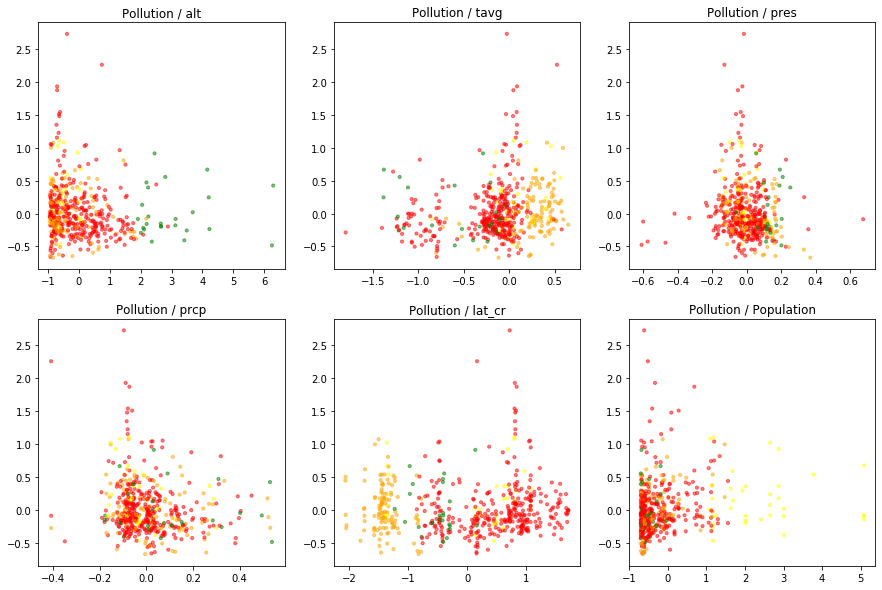

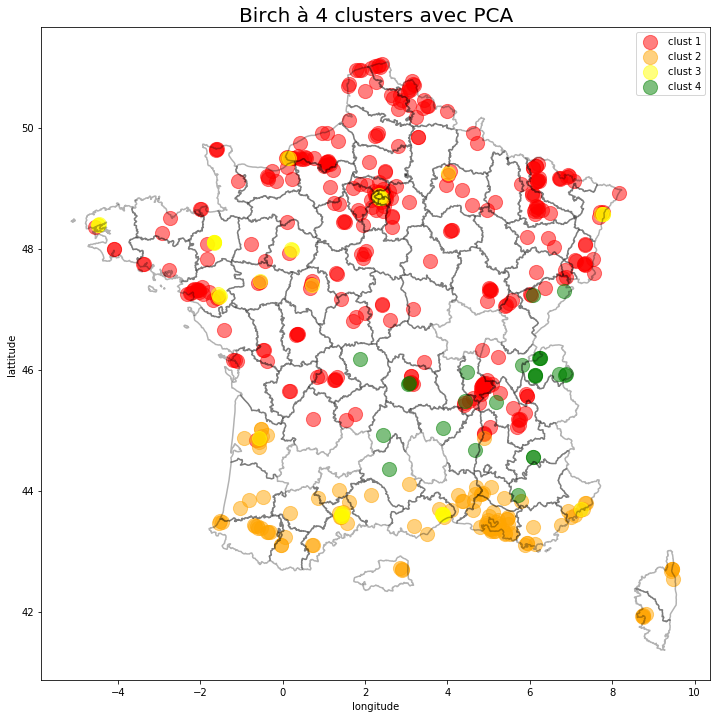

In [33]:
BC(df_mean,nb_clust=4, nb_comp_pca = 3)

# DBSCAN

In [34]:
# clustering par dbscan:
def DB(df, epsilon = 0.5, ms = 5, graph = True):
    dfk = df.fillna(0)
    #.loc[df_mean['GDH'].dt.]
    #dfk = dfk.loc[dfk['mean']<10]

    dbscan_algo = cluster.DBSCAN(eps = epsilon, min_samples = ms)
    dbscan_results = dbscan_algo.fit(dfk[['mesure', 'Population',
                                                    'alt', 
                                                    'lat_cr', 'long_cr',
                                                    #'PicJourConsoNat',
                                                    #'lat', 'long',
                                                    'tavg', 'prcp',  'pres' 
                                                    ]])

    dfk['classification'] = dbscan_results.labels_
    nb_clust = max(dfk['classification'])
    colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(nb_clust+1)])
    #création d'une liste comportant tous les binômes de paramètres étudiés

    if graph == True:
        # Affichage sur la carte
        plt.figure(figsize=(12,12))
    
    # on rajoute le dept 11 qui n'a pas de station de mesure si le Df prend en compte toute la France
    if set(dfk['Code Département']) == set(df_tot['Code Département']):
        dep(list(set(dfk['Code Département']))+['11'])
    else:
        dep(set(dfk['Code Département']))
    
    for i in set(dbscan_results.labels_):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'], 
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha = 0.5,
                    c=colormap[i],
                    label = f'clust {str(i+1)}')
        
    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    plt.title(f'dbscan à {nb_clust} clusters', size = 20)
    if graph == True:
        plt.legend()
        plt.show()

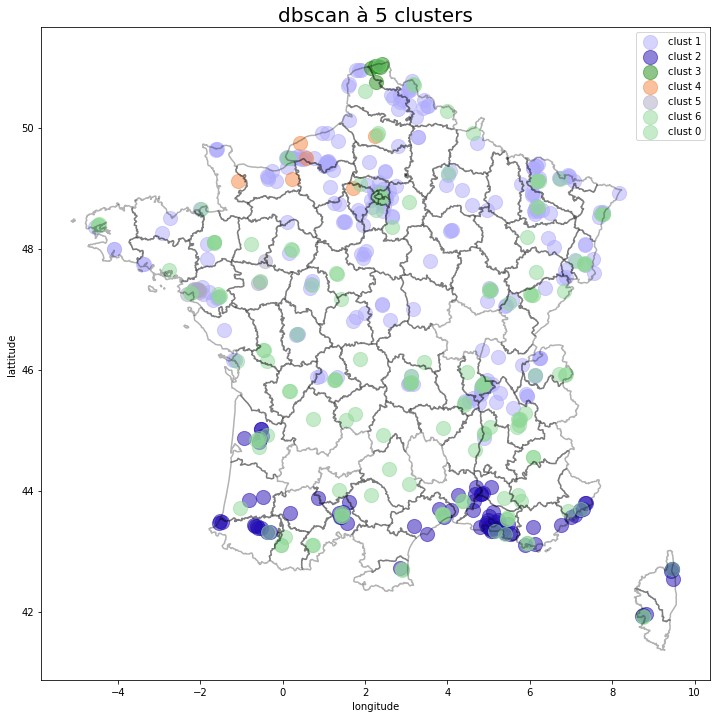

In [35]:
DB(df_mean, epsilon =0.6, ms = 6)

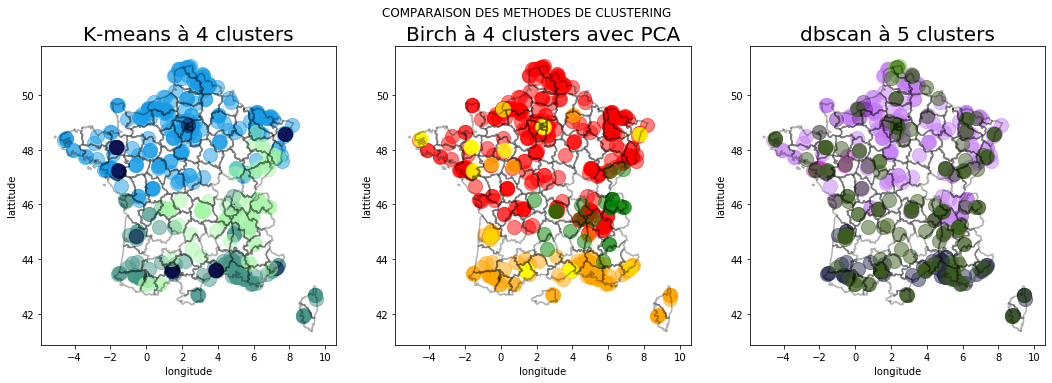

In [41]:
# regroupement des trois méthodes de clustering sur la France entière
plt.figure(figsize = (18,5.5))
plt.suptitle('COMPARAISON DES METHODES DE CLUSTERING')
plt.subplot(131)
km(df_mean, 4, graph = False)
plt.subplot(132)
BC(df_mean,nb_clust=4, nb_comp_pca = 3, graph = False)
plt.subplot(133)
DB(df_mean, epsilon =0.6, ms = 6, graph = False)
plt.show()

# Prédiction

In [ ]:
# jeu de test jusqu'au sur deux ans du 17/09/2018 au 16/09/2020
# jeu de validation du 17/09/2020 au 07/03/2021

In [122]:
df_meanpoll = df_tot.groupby([ 'code site','GDH']).agg({'PicJourConsoNat': 'first', 'mesure': 'mean', 
                                                        'lat': 'first','long': 'first', 
                                                        'alt': 'first', 
                                                        'Population': 'first', 
                                                        'tavg': 'mean', 'prcp': 'mean', 'pres': 'mean',
                                                        #'Jx': 'first', 'Jy': 'first'
                                                       })

#df_meanpoll = df_meanpoll.reset_index().drop('code site', axis = 1)
#df_meanpoll.columns
dic = {i: df_meanpoll.loc[i] for i in set(df_tot['code site'])}

In [133]:
def pred(site):
    y = dic[site]['mesure']
    y_train, y_test = y[:'16/09/2020'], y['17/09/2020':]
    if len(y_train)>0 and len(y_test) >0:
        X = dic[site].drop('mesure', axis = 1)
        X_train, X_test = X[:'16/09/2020'], X['17/09/2020':]
        reg_lin = linear_model.LinearRegression().fit(X_train, y_train)
        return reg_lin.score(X_train, y_train)
    else:
        return 0

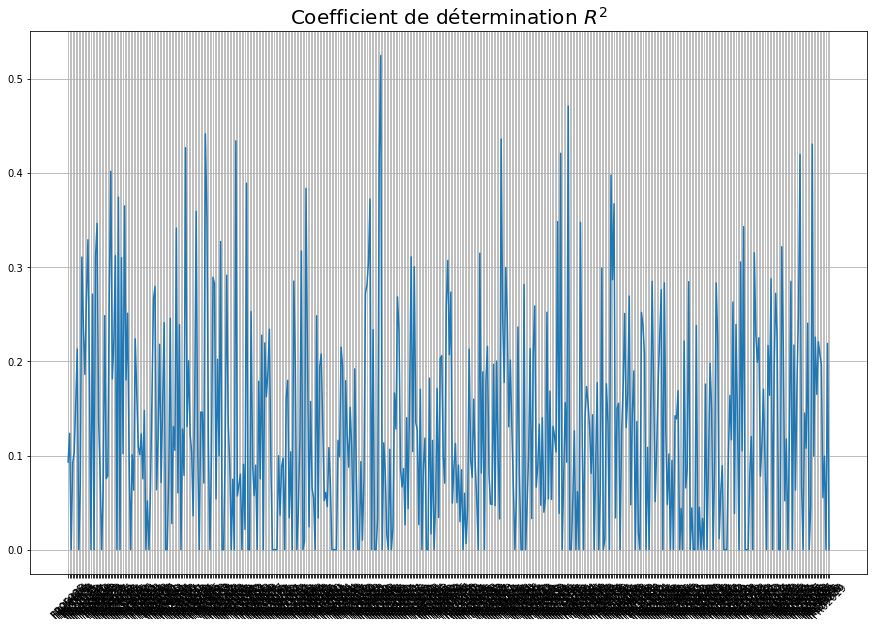

In [196]:
sites = list(set(df_tot['code site']))
scores = [pred(i) for i in sites]
plt.figure(figsize = (15,10))
plt.plot(sites, scores)
plt.title('Coefficient de détermination $R^2$', size = 20)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [227]:
def graph_pred(site, graph = True):
    y = dic[site]['mesure']
    y_train, y_test = y[:'16/09/2020'], y['17/09/2020':]
    X = dic[site].drop('mesure', axis = 1)
    X_train, X_test = X[:'16/09/2020'], X['17/09/2020':]
    reg_lin = linear_model.LinearRegression().fit(X_train, y_train)
    
    if graph == True:
        plt.figure(figsize=(15,10))
        
    y_pred0 = pd.DataFrame(reg_lin.predict(X_train), index = y_train.index)[1:]
    y_pred1 = pd.DataFrame(reg_lin.predict(X_test), index = y_test.index)
    plt.plot(y_pred0, label = 'pred train', alpha = 0.5)
    plt.plot(y_train[1:], label = 'vrai train', alpha = 0.5)
    plt.plot(y_pred1, label = 'pred test', alpha = 0.5)
    plt.plot(y_test, label = 'vrai test', alpha = 0.5)
    commune = [i for i in str(df_sites.loc[df_sites['code site'] == site, 'Commune']).split(" ") if len(i) >0][1].split('\n')[0]
    plt.title(commune)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    if graph == True:
        plt.show()

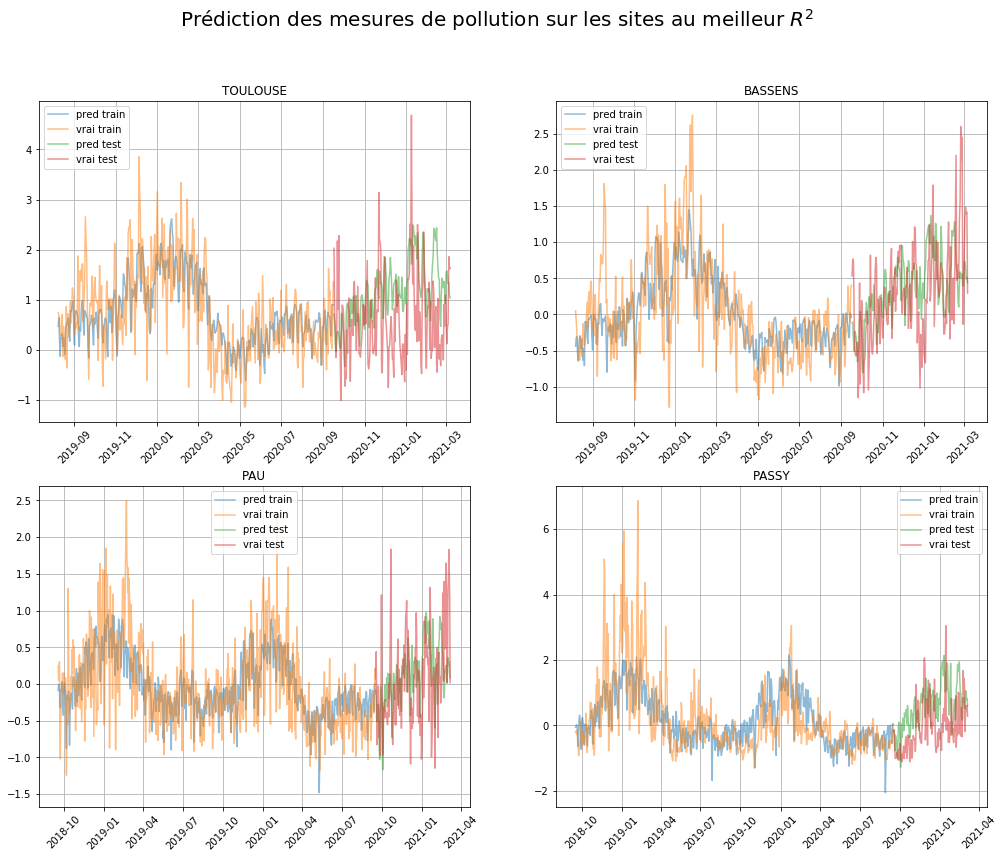

In [228]:
top_sites = [sites[scores.index(i)] for i in sorted(scores, reverse = True)[:4]]
plt.figure(figsize = (17,13))
plt.suptitle('Prédiction des mesures de pollution sur les sites au meilleur $R^2$', size = 20)

for i in range(len(top_sites)):
    plt.subplot(2,2,i+1)
    graph_pred(top_sites[i], graph = False)

plt.show()

In [85]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [88]:
reg_lass = linear_model.LassoCV(cv=5).fit(X_train, y_train)
reg_lass.score(X_train, y_train)

0.015848503467981834

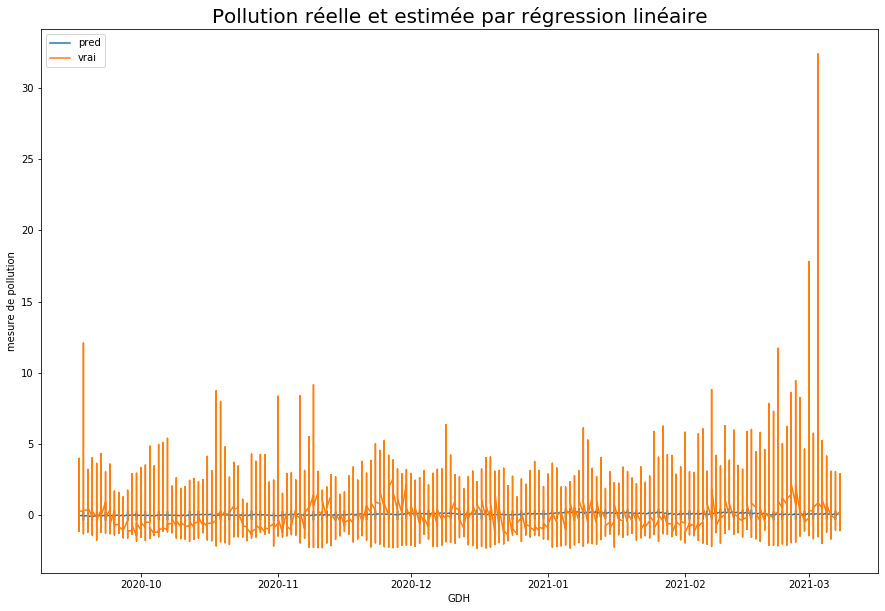

In [89]:
plt.figure(figsize = (15,10))
plt.plot(pd.DataFrame(reg_lass.predict(X_test), index = y_test.index), label = 'pred')
plt.plot(y_test, label = 'vrai')
plt.xlabel('GDH')
plt.ylabel('mesure de pollution')
plt.title('Pollution réelle et estimée par régression linéaire', size = 20)
plt.legend()
plt.show()

# Etude du confinnement en IDF

In [ ]:
df_tot.set_index('GDH', inplace = True)
df_conf = df_tot.loc['01/2020':'06/2020'].reset_index()
code_IDF = set(df_sites.loc[df_sites['Code Département'].isin(IDF), 'code site'])
df_conf = df_conf.loc[df_conf['code site'].isin(code_IDF)]
df_conf = df_conf.groupby(['code site', 'GDH']).agg({'PicJourConsoNat': 'mean', 'mesure': 'mean'}).reset_index()

In [ ]:
plt.figure(figsize=(15,10))

for site in code_IDF:
    a = df_conf.loc[df_conf['code site'] == site]
    plt.plot(a['GDH'], a['mesure'], alpha = 0.3)

df_conf_mean = df_conf.groupby('GDH').agg({'PicJourConsoNat': 'mean', 'mesure': 'mean'})
plt.plot(df_conf_mean.index, df_conf_mean['mesure'], color = 'red', linewidth = 5, 
         label = 'pollution moyenne en IDF')
df_conf_mean['PicJourConsoNat'] = (df_conf_mean['PicJourConsoNat'] - df_conf_mean['PicJourConsoNat'].mean()) / df_conf_mean['PicJourConsoNat'].std()
plt.plot(df_conf_mean.index, df_conf_mean['PicJourConsoNat'], color = 'blue', linewidth = 5, 
         label = 'consommation nationale')
plt.legend()
plt.grid()
plt.show()